# AMLD-2021-Sketchy: Training

Purpose: This notebook provides a walk through the process of retrieving photos of the same class as a hand-drawn sketch with the model proposed in [Doodle to Search: Practical Zero-Shot Sketch-based Image Retrieval](http://dagapp.cvc.uab.es/doodle2search/CVPR2019.pdf). 
Complementary information and studies on the model can be found in [here](http://dagapp.cvc.uab.es/doodle2search/CVPR2019_Supplementery.pdf).

Contrarily to the paper above, we perform here a non-zero shot inference, which means that the classes in training, validation and testing are the same (only sketches and images are different). Moreover, we did not implement all the parts associated with the semantic loss. Further explanation are provided in the model description part.

In [1]:
# Loads the autoreload package into ipython kernel and set it to automatically reload modules
# when they change
%load_ext autoreload
%autoreload 2

#!git clone https://https://github.com/VisiumCH/AMLD-2021-Sketchy.git

#%cd AMLD-2021-Sketchy/

#!make env
#!source env/bin/activate
#!make init
%pwd

'/home/pauline.maury/AMLD-2021-Sketchy/notebooks/workshop'

## Package Import

In [2]:
# Python imports
import os
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from glob import glob
from tqdm import tqdm
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.models as vision_models
from torch.utils.data import DataLoader
from torchvision import transforms

# Codebase imports
from src.data.loader_factory import load_data
from src.data.utils import default_image_loader
from src.models.loss import GradReverse
from src.models.utils import load_checkpoint

## Model description

### Quick overview

The photo retrieval task aims to return photos that are in the same class as sketches drawn by hand.

Therefore, two encoders are trained: one for photos and one for sketches. Each encoder maps its input (photo or sketch) to an embedding space E.

Then, the embeddings are ranked by similarity based on their euclidean distance in the embedding space and the most similar photos to the sketch  are retrieved.

<img src="images/graph.png">

### Problem Formulation

We have:

$$\begin{align}
& X = \{x_i\}^N_{i=1} 
& l_x : X → C \\
& Y = \{y_i\}^M_{i=1} 
& l_y : Y → C \\
\end{align}$$

with $X$ the set of photos, $Y$ the set of sketches, $C$ the set of all possible categories and $l_x$ and $l_y$ the two labelling functions for photos and sketches respectively.

### Encoder Networks
Given a distance function d(·, ·), the aim of the framework is to learn two embedding functions $Ф : X → R^D$ and $Ψ : Y → R^D$, which respectively map the photo and sketch domain into a common embedding space.

Given two photos $x_1, x_2 ∈ X$ and a sketch $y ∈ Y$, it is expected that the embeddings fulfill the following condition:

$$\begin{align}
& d(Ф(x_1), Ψ(y)) < d(Ф(x2), Ψ(y)), \\
& when \quad l_x(x_1) = l_y(y) \quad and \quad l_x(x_2) ≠ l_y(y) \\
\end{align}$$

meaning that there is a shorter distance when photos and sketch belong to the same class, then when they don't. Here, $d$ is the euclidean distance.

The embedding function $Ф(·)$ and $Ψ(·)$ are defined as two CNNs with attention: VGG 16 networks where the last fully-connected layer has been replaced to match the embedding size E. The attention mechanism helps the system
to localise the important features and is learned end-to-end with the rest of the network. The output of the attention module is computed by $f + f * att$.

### Learning Objectives

The learning objective of the framework combines two losses: the <i>Triplet Loss</i> and the <i>Domain Loss</i>.

Let $\{a, p, n\}$, where $a ∈ Y$, $p ∈ X$ and $n ∈ X$ be respectively the anchor, positive and negative samples during the training and $l_x(p) = l_y(a)$ and $l_x(n) ≠ l_y(a)$.

#### Triplet loss: 
This loss aims to reduce the distance between embedded sketch and image if they belong to the same class and increase it if they belong to different classes.

Defining distance between samples as $δ_+ = ||Ψ(a) − Ф(p)||_2$ and $δ_- = ||Ψ(a) − Ф(n)||_2$ for the positive and negative samples respectively, then, the ranking loss for a particular triplet can be formulated as $λ(δ_+, δ_−) = max\{0, µ+δ_+ −δ_−\}$ where $µ > 0$ is a margin parameter. 


Batch-wise, the loss is defined as:
$$\begin{align}
& L_t = \frac{1}{N}\sum_{i=1}^{N} λ(δ^i_+, δ^i_-) \\
\end{align}$$

 
the order aimed by this loss is $δ_− > δ_+ + µ$, if this is the case, the network is not updated, otherwise, the weights of the network are updated accordingly.

#### Domain loss:
This loss aims to explicitly enforce the mapping of sketch and image samples to a common space.

Given the embedding $Ф(·)$ and $Ψ(·)$, we make use of a Multilayer Perceptron (MLP) as a binary classifier $f(·)$ trying to predict which was the initial domain. Purposefully, in order to create indistinguishable embedding we use a Gradient Reversal Layer (GRL) defined as $R_{λ_d}(·)$, which applies the identity function during the forward pass $R_{λ_d}(x) = x$,
whereas during the backward pass it multiplies the gradients by the meta-parameter $−λ_d$, $\frac{dR_{λ_d}}{dx}= −{λ_d}I$. This operation reverses the sign of the gradient that flows through the CNNs. The meta-parameter $λ_d$ changes from 0 (only trains the classifier but does not update the encoder network) to 1 during the training. 
Here, before the 5th epoch $λ_d=0$, after the 25th $λ_d=1$, and in-between $λ_d(epoch) = (epoch − 5)/20$

With $f : R^D → [0, 1]$ as the MLP function and $e ∈ R^D$ as an embedding coming from the encoders network. We can define the binary cross entropy of one of the samples as $l_t(e) = tlog(f(R_{λ_d}(e))) + (1 − t) log(1 − f(R_{λ_d}(e)))$, where $e$ is the embedding obtained by the encoder network and $t$ is 0 for sketch and 1 for photo. Hence, the domain loss is defined as:

$$\begin{align}
& L_d = \frac{1}{3N}\sum_{i=1}^{N} ( l_0(Ψ(a_i)) + l_1(Ф(p_i)) + l_1(Ф(n_i)) ) \\
\end{align}$$

See the paper for additional information.

## Global Parameters Declaration

In [3]:
class Args:
    dataset = "sketchy"
    data_path = '../../io/data/raw/'
    save = '../../io/models/sktu_copy/'
    load = save + 'checkpoint.pth'
    embeddings_path = save + '00053/default/'
    
    emb_size = 256
    cuda = False
    seed = 42
    
    max_images_test = 10
    training_split = 0.8
    valid_split = 0.1
    batch_size = 10
    prefetch = 2
    attn = True
    margin = 1
    
args = Args()

## The Data

In [4]:
# Note: the code here is simplified, only choose sketchy or quickdraw as dataset.
assert args.dataset in ['sketchy', 'quickdraw']

In [5]:
transform = transforms.Compose([transforms.ToTensor()])

In [6]:
# We will only use the train and test data for this notebook
train_data, [_, _], [test_sk_data, test_im_data], dict_class_to_id = load_data(args, transform)

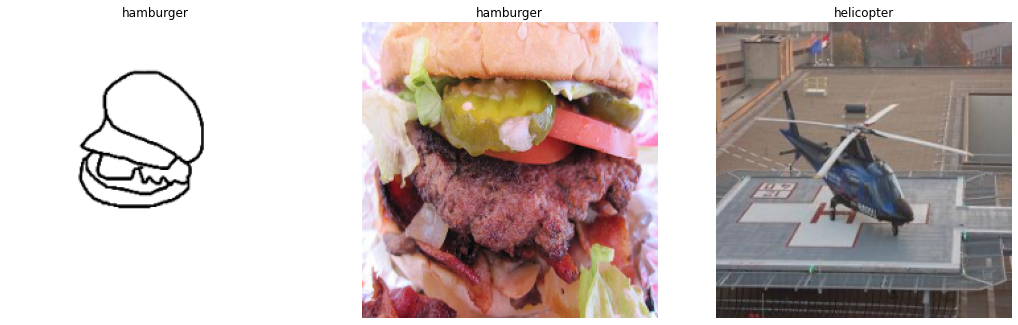

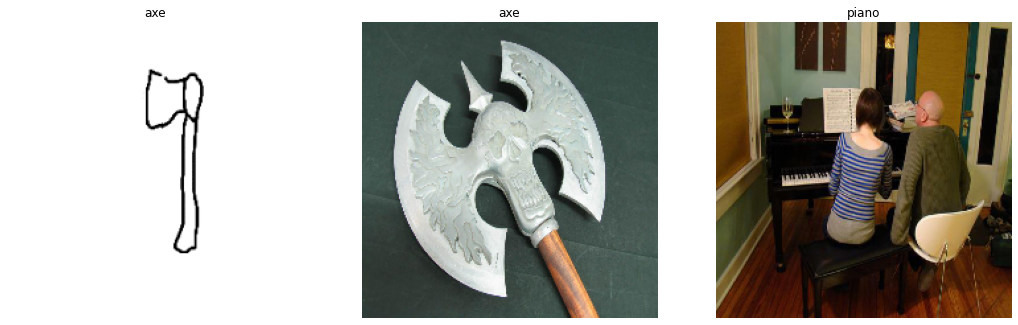

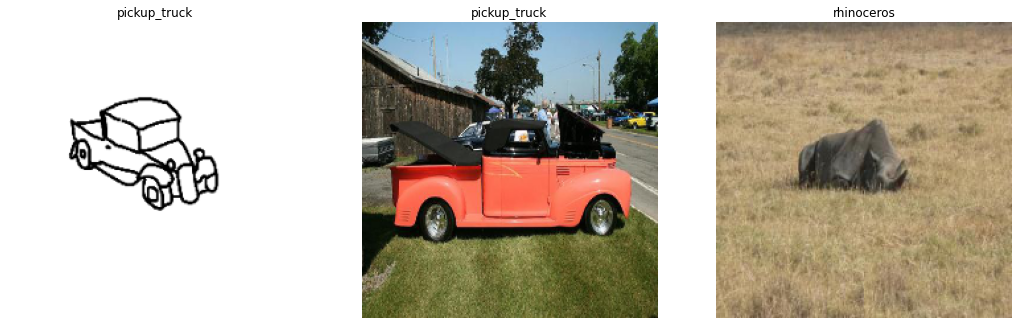

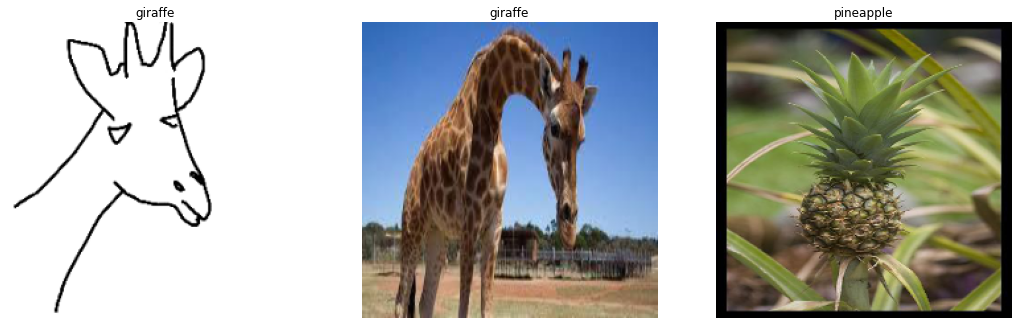

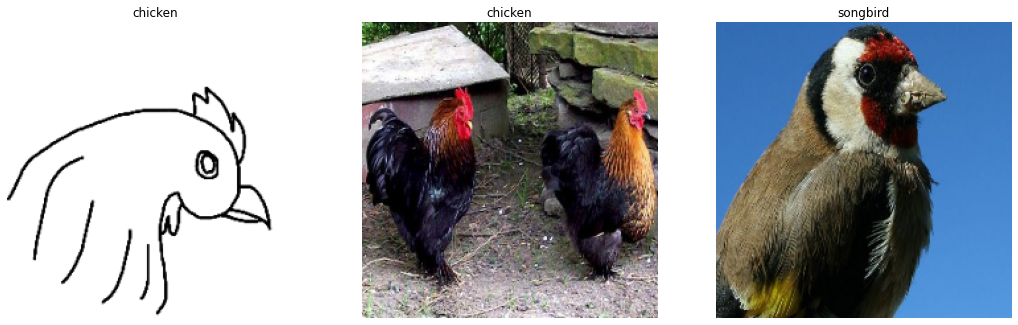

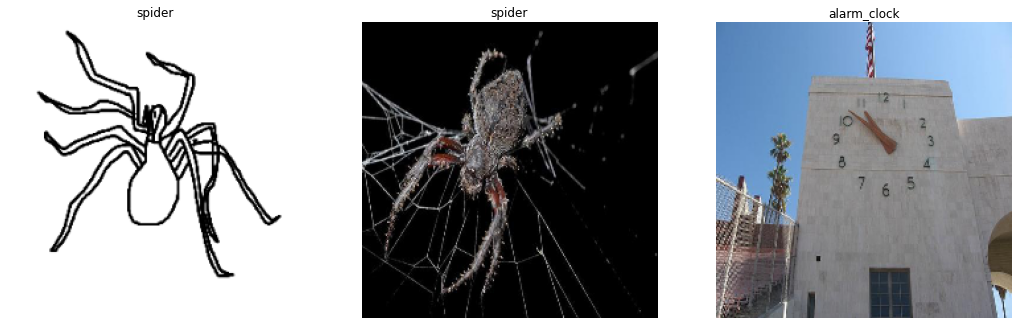

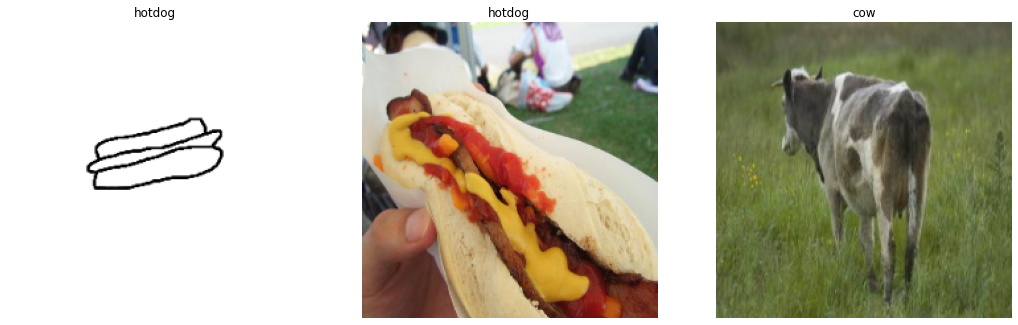

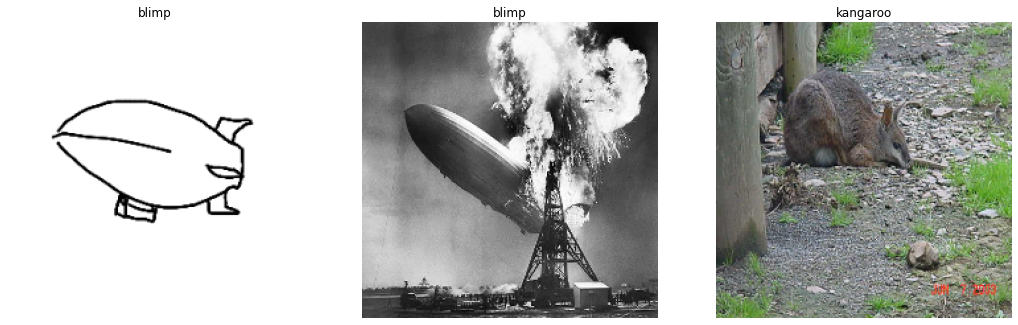

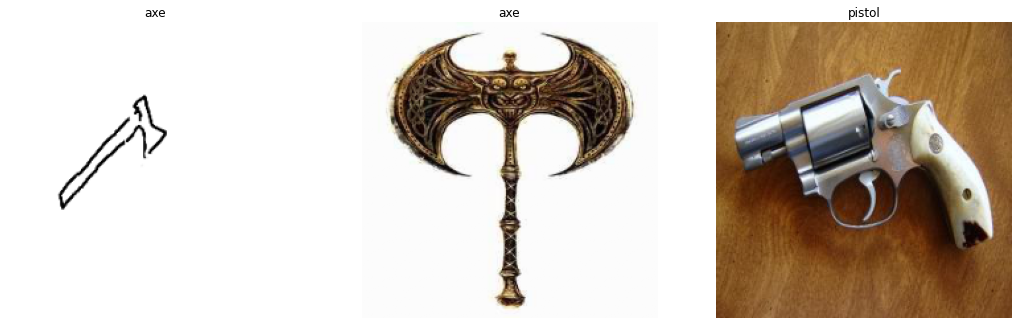

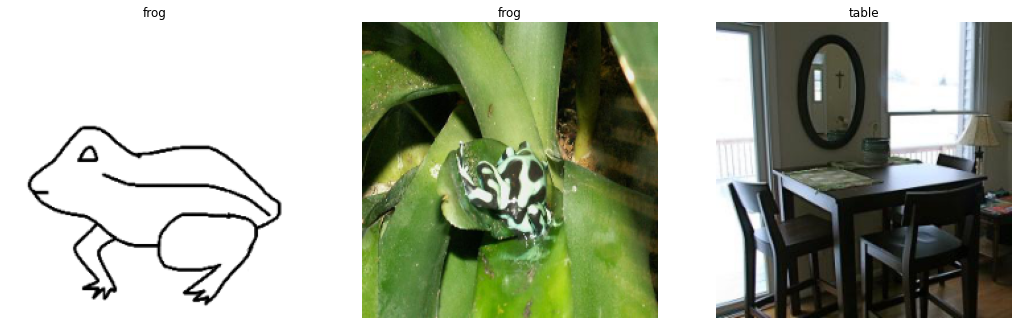

In [7]:
# Let's now load and visualize some training data
train_loader = DataLoader(train_data, batch_size=args.batch_size, shuffle=True,
                          num_workers=args.prefetch, pin_memory=args.cuda, drop_last=True)

# We will work on a single batch
sketchs, positive_images, negative_images, positive_labels, negative_labels = next(iter(train_loader))
positive_labels, negative_labels = positive_labels.numpy(), negative_labels.numpy()

# Reverse dict to go from id to class
dict_id_to_class = {v:k for k,v in dict_class_to_id.items()}

for i in range(args.batch_size):
    fig, ax = plt.subplots(1, 3, figsize=(18,6))
    
    ax[0].imshow(sketchs[i].permute(1,2,0).numpy())
    ax[0].set_title(dict_id_to_class[positive_labels[i]])
    ax[0].axis("off")

    ax[1].imshow(positive_images[i].permute(1,2,0).numpy())
    ax[1].set_title(dict_id_to_class[positive_labels[i]])
    ax[1].axis("off")

    ax[2].imshow(negative_images[i].permute(1,2,0).numpy())
    ax[2].set_title(dict_id_to_class[negative_labels[i]])
    ax[2].axis("off")
    
plt.show()

# Training
## The Model

In [8]:
class AttentionModel(nn.Module):
    def __init__(self, hidden_layer=380):
        super(AttentionModel, self).__init__()

        self.attn_hidden_layer = hidden_layer
        self.net = nn.Sequential(nn.Conv2d(512, self.attn_hidden_layer, kernel_size=1),
                                 nn.Conv2d(self.attn_hidden_layer, 1, kernel_size=1))

    def forward(self, x):
        attn_mask = self.net(x)
        attn_mask = attn_mask.view(attn_mask.size(0), -1)
        attn_mask = nn.Softmax(dim=1)(attn_mask)
        attn_mask = attn_mask.view(attn_mask.size(0), 1, x.size(2), x.size(3))
        x_attn = x * attn_mask
        x = x + x_attn
        return x, attn_mask
    
class EncoderCNN(nn.Module):
    def __init__(self, out_size=300, pretrained=True, attention=True):
        super(EncoderCNN, self).__init__()
        # Embedd images in a 1000 space
        vgg_aux = vision_models.vgg16_bn(pretrained)
        self.cnn_features = vgg_aux.features

        # Attention model
        self.attention = attention

        self.attn = AttentionModel()

        self.map = vgg_aux.classifier
        self.map._modules['6'] = nn.Linear(4096, out_size)

    def forward(self, im):
        x = self.cnn_features(im)  # Size (BS x 512 x 7 x 7)

        if self.attention:
            x, attn_mask = self.attn(x)  # Size (BS x 512)

        x = x.view(x.size(0), -1)

        x = self.map(x)
        if not self.attention:
            attn_mask = torch.zeros(7, 7)
        return x, attn_mask

In [9]:
# We create the model
im_net = EncoderCNN(out_size=args.emb_size, attention=args.attn)
sk_net = EncoderCNN(out_size=args.emb_size, attention=args.attn)

## Losses

To work with the losses, let's first get the embeddings of the images from the first batch.

In [10]:
im_net.train()
sk_net.train()
torch.set_grad_enabled(True)

checkpoint = load_checkpoint(args.load)
im_net.load_state_dict(checkpoint["im_state"])
sk_net.load_state_dict(checkpoint["sk_state"])

positive_image_embeddings, _ = im_net(positive_images)
negative_image_embeddings, _ = im_net(negative_images)
sketch_embeddings, _ = sk_net(sketchs)

=> loading model '../../io/models/sktu_copy/checkpoint.pth'
=> loaded model '../../io/models/sktu_copy/checkpoint.pth' (epoch 49, map 0.3094873427878774)


### Triplet loss

**TODO**: Implement the triplet loss step by step based on the formulas provided in the Learning Objectives' Triplet Loss.

*N.B*: This loss is implemented in PyTorch as nn.TripletMarginLoss

In [11]:
def calculate_triplet_loss(sketch_embeddings, positive_image_embeddings, negative_image_embeddings):
    
    triplet_loss = ... # Implement me !
    return triplet_loss

In [12]:
def calculate_triplet_loss_solution(sketch_embeddings, positive_image_embeddings, negative_image_embeddings):
    
    # Compute distance for positive and negative samples
    delta_plus = torch.linalg.norm(sketch_embeddings - positive_image_embeddings, axis=1, ord=2)
    delta_minus = torch.linalg.norm(sketch_embeddings - negative_image_embeddings, axis=1, ord=2)

    # Calculate difference (with margin) and take the max(0, _lambda)
    _lambda = args.margin + delta_plus - delta_minus
    _lambda[_lambda<0] = 0

    # Calculate loss batch-wise
    triplet_loss = torch.mean(_lambda)
    return triplet_loss

In [13]:
triplet_loss = calculate_triplet_loss_solution(sketch_embeddings, positive_image_embeddings, negative_image_embeddings)
triplet_loss

tensor(0.2900, grad_fn=<MeanBackward0>)

### Domain Loss

For this loss, we already have implemented the reverse gradient and the loss from the binary classifier (MLP)

**TODO**: Implement the domain loss (see Learning Objectives: Domain Loss)

In [14]:
def grad_reverse(x, lambd=0.5):
    '''
    Forward pass R(x) = x
    Backward pass R(X) = -λx
    '''
    return GradReverse.apply(x, lambd)

class DomainLoss(nn.Module):
    '''Ensures that embeddings belong to the same space'''

    def __init__(self, input_size=256, hidden_size=64):
        super(DomainLoss, self).__init__()
        self.input_size = input_size
        # self.map = nn.Linear(self.input_size, 1)
        self.map = nn.Sequential(
            nn.Linear(self.input_size, hidden_size),
            nn.ReLU(True),
            nn.Dropout(),
            nn.Linear(hidden_size, hidden_size),
            nn.ReLU(True),
            nn.Linear(hidden_size, 1),
        )

    def forward(self, input, target):
        input = self.map(input)
        input = torch.sigmoid(input).squeeze()
        return F.binary_cross_entropy(input, target)

In [15]:
def get_lambda_d(epoch):
    lambda_d = ... # Implement me!
    return lambda_d

def calculate_domain_loss(sketch_embeddings, positive_image_embeddings, negative_image_embeddings, epoch):
    # Get Lambda
    lambda_d = get_lambda_d(epoch)
    
    # Outputs the binary cross entropy between the input and the target
    domain_loss = DomainLoss(input_size=args.emb_size)

    # Hint: 1. create the target for the classification between sketch and images.
    #       2. add the backward pass of the binary crossentropy between inputs and targets.
    
    loss_dom = ... # Implement me !
    return loss_dom

In [16]:
def get_lambda_d_solution(epoch):
    
    lambda_d = (epoch-5)/20
    lambda_d = np.clip(lambda_d, 0, 1)
    return lambda_d

def calculate_domain_loss_solution(sketch_embeddings, positive_image_embeddings, negative_image_embeddings, epoch):
    # Get Lambda
    lambda_d = get_lambda_d_solution(epoch=10)
    
    # Outputs the binary cross entropy between the input and the target
    domain_loss = DomainLoss(input_size=args.emb_size)

    targetSK = torch.zeros(args.batch_size)
    targetIM = torch.ones(args.batch_size)

    loss_dom_sk = domain_loss(grad_reverse(sketch_embeddings, lambd=lambda_d), targetSK)
    loss_dom_pos_im = domain_loss(grad_reverse(positive_image_embeddings, lambd=lambda_d), targetIM)
    loss_dom_neg_im = domain_loss(grad_reverse(negative_image_embeddings, lambd=lambda_d), targetIM)
    loss_dom = torch.mean(loss_dom_sk + loss_dom_pos_im + loss_dom_neg_im)
    return loss_dom

In [17]:
loss_dom = calculate_domain_loss_solution(sketch_embeddings, positive_image_embeddings, negative_image_embeddings, epoch=10)
loss_dom

tensor(2.0715, grad_fn=<MeanBackward0>)

### Final Loss

**TODO**: And now get the final loss weighting the domain and the triplet loss!

In [18]:
def calculate_final_loss(
    sketch_embeddings,
    positive_image_embeddings,
    negative_image_embeddings,
    epoch,
    w_triplet = 1,
    w_domain = 1
):
    
    loss = ... # Implement me !
    return loss

In [19]:
def calculate_final_loss_solution(
    sketch_embeddings,
    positive_image_embeddings,
    negative_image_embeddings,
    epoch,
    w_triplet = 1,
    w_domain = 1
):
    triplet_loss = calculate_triplet_loss_solution(sketch_embeddings, positive_image_embeddings, negative_image_embeddings)
    domain_loss = calculate_domain_loss_solution(sketch_embeddings, positive_image_embeddings, negative_image_embeddings, epoch)
    loss = w_triplet * triplet_loss + w_domain * domain_loss
    return loss

In [20]:
loss = calculate_final_loss_solution(sketch_embeddings, positive_image_embeddings, negative_image_embeddings, epoch=10)
loss

tensor(2.4101, grad_fn=<AddBackward0>)